# Standard example of Lompe

This notebook is an example of how to use the implemented `lompe` technique to combine available measurements to get a complete two-dimensional map of the electrodynamics in a local region. 

The Lompe (LOcal Mapping of Polar ionospheric Electrodynamics) technique is based on spherical elementary current systems (SECS), the ionospheric Ohm's law, and cubed-sphere grids. A model vector, $\mathrm{\underline{m}}$ - a set of curl-free SECS basis function amplitudes describing the ionospheric electric field - is found from input data, $\mathrm{\underline{y}}$, by solving the equation 
\begin{equation}
    \mathrm{\underline{y}}=\mathbb G \mathrm{\underline{m}}
\end{equation}
for $\mathrm{\underline{m}}$. $\mathbb G$ is the design matrix containing SECS equations that relate ionospheric parameters to the model vector. Once $\mathrm{\underline{m}}$ is known, the same equation (with an updated design matrix $\mathbb G$) can be used to obtained a set of *predictions* of ionospheric parameters, $\mathrm{\underline{y}}$. The full explanation of the technique can be found in [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356). 

In this notebook we will:
1. Set up a local cubed-sphere grid that is offset from the Geographic North Pole and rotated 45$^\circ$ northward
2. Use the implemented conductance models to get ionospheric conductance
3. Prepare input data to Lompe - an ionospheric electric field
4. Run the Lompe inversion to get the model vector, $\mathrm{\underline{m}}$
5. Plot the model predictions (Lompe output) using `lompeplot`
6. Show how model predictions of ionospheric parameters can be extracted from the model for any location within the analysis region

For this example, we are using an electric field, $\mathbf{E}$, derived from an ionospheric electric potential, $\Phi$, from the [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model (with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$; see Notebook 01) as synthetic input data. The ionospheric conductance functions from `hardy_EUV()` are used. We set the time to 2 July 2015 at 11:50 UT and the Kp index to 4 (see Notebook 03).

More examples of the Lompe technique can be found in the */lompe_paper_figures/* folder.

*Change note (June 2023)*: Updated notebook to use the new `error` and `iweight` keywords instead of `scale`

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import apexpy
from scipy.interpolate import griddata

RE = 6371.2e3                          # Earth's radius [m]
HI = 110e3                             # ionospheric altitude [m]
stencil_size = 1                       # size of stencil for differentiation 
time = dt.datetime(2015, 7, 2, 11, 50) # used for coordinate conversion, coastlines, and solar zenith angles

#### Cubed-sphere grid
We set up cubed-sphere grid over a region of North America. The grid is centered at 88$^{\circ}$W and 72$^{\circ}$N (geographic, global system is geographic, see Notebook 01), is 7000$\times$5000 km, is rotated 45$^{\circ}$ (towards the north), and has a resolution of 100$\times$100 km. The grid is set to an ionospheric altitude of 110 km.

In [2]:
L, W, Lres, Wres = 7000e3, 5000e3, 100e3, 100e3  # [m]
orientation = 45         # angle defining orientation of xi-axis w.r.t. the northward direction
projection = lompe.cs.CSprojection((-88, 72), orientation)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R=RE+HI)  # set grid to ionospheric altitude

We can plot coastlines and latitudes on the grid to visualize which region the grid covers (the last figure in this notebook also shows the grid projection on an magnetic latitude, MLT coordinate system). This can be useful for adjusting the grid so that it covers the most data-dense region.

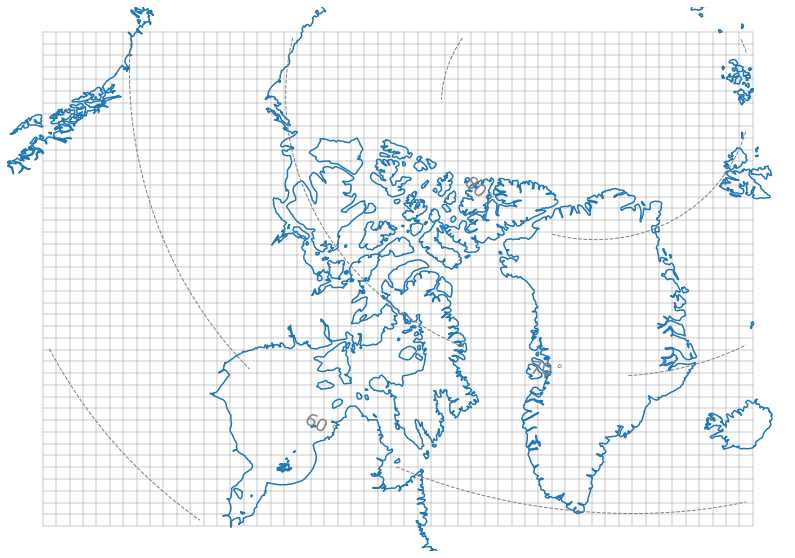

In [3]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.set_axis_off()

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)
xlim, ylim = ax.get_xlim(), ax.get_ylim()

# coastlines
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color='C0')

# add geographic latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles='--', colors='grey', linewidths=1, levels=np.r_[-80:81:10])
ax.clabel(co, co.levels, inline=True, fontsize=18, fmt='%1.0f$^\circ$')

ax.set_xlim(xlim)
ax.set_ylim(ylim);

#### Ionospheric conductances
The Lompe technique requires that the ionospheric conductances are defined across the entire grid. We use the implemented `hardy_EUV()` conductance models to get functions for the conductances (more details in Notebook 03).

In [4]:
Kp   = 4     # for Hardy model
F107 = 100   # for EUV conductance

# functions for conductances to be passed to the Lompe model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'pedersen')

#### Input data - electric field
We get the electric field on our grid region from the Weimer potential, $\Phi$, by following the steps outlined in Notebook 01:

In [5]:
# read potential file
weimer = np.load('./datasets/interpolated_weimer.npz')
Phi = weimer['Phi']
mlatxx = weimer['lat'] # magentic lat
mlonxx = weimer['lon'] # magnetic lon
mltxx = mlonxx/15.     # 0 deg magnetic lon at midnight MLT

# on grid axis
apex = apexpy.Apex(time, HI*1e-3)
mlonxx = apex.mlt2mlon(mltxx, time)
latxx, lonxx, _ = apex.apex2geo(mlatxx, mlonxx, HI*1e-3) # to geographic coordinates

# interpolate potential to grid 
xi, eta = grid.projection.geo2cube(lonxx, latxx) # to cube coordinates
mask = np.isnan(xi) # remove nans
Phi = griddata((xi[~mask].flatten(), eta[~mask].flatten()), Phi[~mask].flatten(), 
               (grid.xi.flatten(), grid.eta.flatten()), fill_value=0, method='cubic').reshape(grid.shape)

# use cubed sphere differentiation matrices to get electric field
De, Dn = grid.get_Le_Ln(S=stencil_size, return_sparse=True)
E_e = -De.dot(Phi.flatten()).reshape(grid.shape)
E_n = -Dn.dot(Phi.flatten()).reshape(grid.shape)
E_tot = np.vstack((E_e.flatten(), E_n.flatten()))

We now have the (synthetic) data we want to use as input data for Lompe. Before passing the data to Lompe, we need to make a `lompe.Data` object. This way we make sure that the data is on the correct format for `lompe.Emodel`, and that the correct equations will be used to construct the SECS design matrices in $\mathbb{G}$.

The electric field array is of shape $(2,N)$, with rows corresponding to the two east and north dimensions of the $N$ data points. Here, this is the same as the $N$ cells in the `CSgrid`, as the electric field is defined on each grid cell. In a real scenario, this is not usually the case, and the number of data points can be different from the number of grid cells, and can have any location (though data points far outside of the `CSgrid` will not be used in the inversion). Note that we do not have any "up" components for the electric field, and we set the `components` parameter to $[0,1]$ (for *components*, 0, 1, 2 are indicies corresponding to eastward, northward, and upward directions).
The coordinates of the data points are (geographic) longitude and latitude of the $N$ data points and has shape $(2,N)$.
The electric field measurements in this example are in the range $\pm$ 30 mV/m, and the error is set to 3 mV/m (the `scale` keyword is deprecated). Note that we need to specify the data type, `datatype='efield'`.

In [6]:
coords = np.vstack((grid.lon.flatten(), grid.lat.flatten())) # E-field is defined on the grid
components = [0,1]                                           # eastward, northward components
# scale = 10e-3                                              # (DEPRECATED) typical scale of electric field values
error = 3e-3                                                 # measurement error (only matters if multiple types of data are combined)
iweight = 1.0                                                # arbitrarily selected "importance weight" (only matters if multiple types of data are combined)

E_field_data = lompe.Data(E_tot, coords, datatype='efield', components=components, iweight=iweight, error=error)#, scale=scale)

#### The Lompe model vector
Now, we can initialize a `Emodel` object, add the input data, and run the inversion to get the model vector, $\mathrm{\underline{m}}$, that can be used to obtain other ionospheric parameters in the region. The regularization parameters $\lambda_1$ and $\lambda_2$ can be specified. They control the damping of the model norm (restricts too large variations between the elements in $\mathrm{\underline{m}}$), and the gradient of SECS amplitudes (charges) in magnetic eastward direction (auroral electrodynamics tends to be aligned in the magnetic east-west direction), respectively. An explanation of the inversion technique and regularization parameters can be found in Section 3.3 of [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356).

In [7]:
# initialize model
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add input data
model.add_data(E_field_data)

# Run inversion. l1 and l2 are regularization parameters
model.run_inversion(l1 = 0.02, l2 = 0.01);

#### Plot and save
The model predictions are most easily shown using `lompeplot` from the `visualization` module:

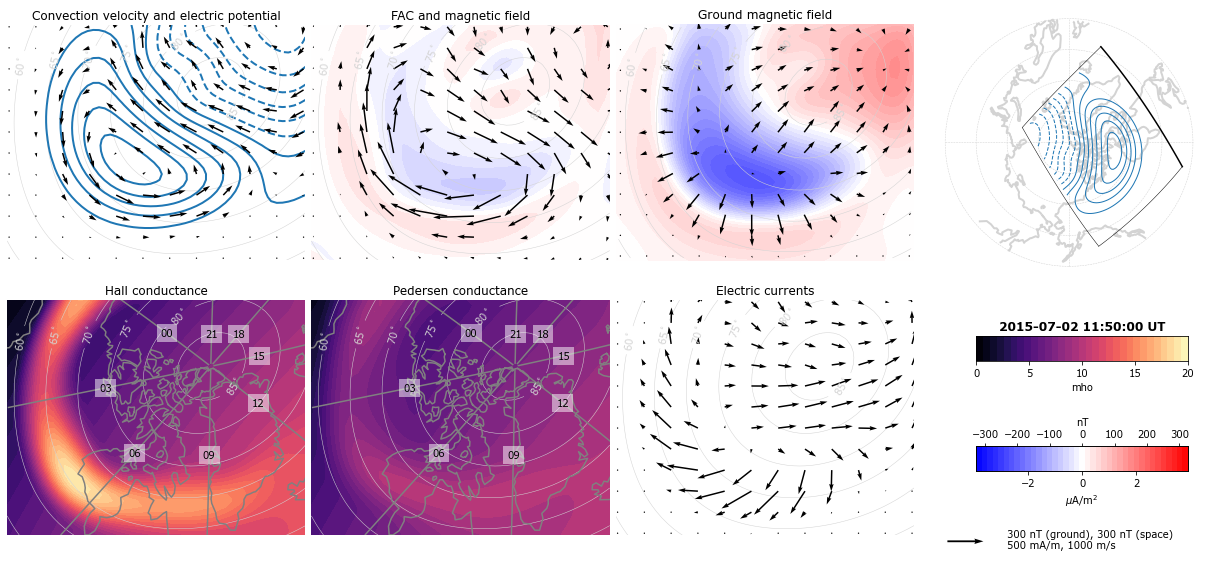

In [8]:
fig = lompe.lompeplot(model, include_data=False, time=time, apex=apexpy.Apex(time), savekw = {'fname':'./output_figures/07standardLompe.pdf'})
# also save png
fig.savefig('./output_figures/07standardLompe.png')

The top row shows, from left to right: 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere (110 km above the grid) as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales

If we set `include_data = True`, orange vectors are used to show the input data in their respective panels. This could be useful to compare model predictions to the input data, though it is not done here, as the input data is defined on the entire grid which would result in a messy figure.

##### Access Lompe predictions for any location in analysis region

You do not have to use `lompeplot` to access the data. The Lompe model object has class methods for accessing individual ionospheric parameters from the model (after the inversion). Predictions for all parameters shown in the figure above can be accessed from the model object for any location:
- Convection electric field (east, north)
- Electric potential (scalar)
- Convection velocity (east, north)
- Space magnetic field (east, north, up) - the height of the evaluation locations is by default twice the height of the ionosphere (grid), but can be set to a preferred altitude above the ionosphere
- Space magnetic field due to FACs (east, north, up) - the height of the evaluation locations is the same as for space magnetic field
- Ground magnetic field (east, north, up) - the height of the evaluation locations is by default the Earth's radius, but can be set to any altitude below the ionosphere
- Horizontal ionospheric surface current density (east, north)
- Field-aligned current density (FAC) (scalar)

In [9]:
# locations we want the modelled ionspheric parameters in
lons, lats = np.array([0, 220]), np.array([90, 70])

# electric field
Emod = model.E(lon=lons, lat=lats)

# electric potential
Epotmod = model.E_pot(lon=lons, lat=lats)

# convection velocity
vmod = model.v(lon=lons, lat=lats)

# magnetic field in space
Bsmod = model.B_space(lon=lons, lat=lats, r=RE+2*HI)   

# space magnetic field due to FACs only
BsFACmod = model.B_space_FAC(lon=lons, lat=lats, r=RE+2*HI)     

# magnetic field on ground
Bgmod = model.B_ground(lon=lons, lat=lats, r=RE)

# horizontal electric current densities
jmod = model.j(lon=lons, lat=lats)

# FACs
FACmod = model.FAC(lon=lons, lat=lats)

If no locations are given, the default evaluation locations are used. For the convection electric field, electric potential, convection velocity, horizontal surface current densities and FACs, the centers of the interior grid points are the default locations. The magnetic field disturbances on ground and in space (both full and due to FACs) have default evaluation locations at the corner of the grid cells (vertices). (See Section 3.1 in [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356) for an example figure).